# Explore water quality data

In [1]:
# Import libraries
import os
import pathlib

import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

In [2]:
# Get path to streams
def fp_to_streams():
    fp = None
    cwd = os.getcwd()
    filename = 'eelis_streams.gpkg'
    if pathlib.Path(cwd) in [pathlib.Path('/gpfs/rocket/samba/gis'), pathlib.Path(r'\\ces.hpc.ut.ee\gis')]:
        fp = os.path.join(cwd, 'holgerv/est_water_qual/data/eelis', filename)
    elif pathlib.Path(cwd) == pathlib.Path('D:/'):
        fp = os.path.join(cwd, 'est_water_qual/data/eelis', filename)
    return fp


# Read water quality observation data
def read_wq_obs(param):
    streams = gpd.read_file(fp_to_streams(), ignore_geometry=True)
    fp = f'est_water_qual/data/kese/{param}_obs.csv'
    dtypes = {
        'Seirekoha KKR': object,
        'Seirekoha nimi': object,
        'Sisestatud x L-EST97': np.float64,
        'Sisestatud y L-EST97': np.float64,
        'Veekogu KKR': object,
        'Proovi / vaatluse  kood': object,
        'Seireaeg': object,
        'Arvväärtus': object,
        'Väärtuse ühik': object
    }
    obs = pd.read_csv(fp, sep=';', usecols=dtypes.keys(), dtype=dtypes, quotechar='"').\
    rename(
    columns={
        'Seirekoha KKR': 'site_code',
        'Seirekoha nimi': 'site_name',
        'Sisestatud y L-EST97': 'x',
        'Sisestatud x L-EST97': 'y',
        'Veekogu KKR': 'wb_code',
        'Proovi / vaatluse  kood': 'obs_code',
        'Seireaeg': 'obs_time',
        'Arvväärtus': 'obs_value',
        'Väärtuse ühik': 'obs_unit'
    })\
    .dropna(subset=['site_code', 'x', 'y'])\
    .pipe(lambda df: df.loc[df['wb_code'].isin(streams['kr_kood'].unique())])\
    .reset_index(drop=True)
    
    # Drop observations from sites of River Narva
    obs = obs[obs['wb_code'] != 'VEE1062200'].reset_index(drop=True)
    
    obs['obs_value'] = obs['obs_value'].str.replace(',', '.').astype(np.float64)
    obs['obs_date'] = pd.to_datetime(obs['obs_time']).dt.strftime('%Y-%m-%d')
    obs['obs_month'] = pd.to_datetime(obs['obs_date']).dt.month
    obs['obs_year'] = pd.to_datetime(obs['obs_date']).dt.year
    return obs


# Get daily observation values
def get_daily_obs(param):
    obs = read_wq_obs(param)
    obs_daily = obs.groupby(['site_code', 'obs_year', 'obs_month', 'obs_date'])['obs_value'].mean().reset_index()
    obs_daily['obs_value'] = obs_daily['obs_value'].round(3)
    return obs_daily


# Get monthly observation values
def get_monthly_obs(obs_daily):
    obs_monthly = obs_daily.groupby(['site_code', 'obs_year', 'obs_month'])['obs_value'].mean().reset_index()
    obs_monthly['obs_value'] = obs_monthly['obs_value'].round(3)
    return obs_monthly


# Get yearly observation values
def get_yearly_obs(obs_daily):
    obs_yearly = obs_daily.groupby(['site_code', 'obs_year'])['obs_value'].mean().reset_index()
    obs_yearly['obs_value'] = obs_yearly['obs_value'].round(3)
    return obs_yearly


# Plot distribution of water quality observation values per year
def plot_wq_hist(obs, param, fp):
    fig, ax = plt.subplots(1, 1)
    sns.histplot(obs, x='obs_value', hue='obs_year', bins=20, multiple='stack', palette='Set1', legend=True, ax=ax)
    ax.set_title(param.upper(), fontsize=12)
    ax.set_xlabel('mg $\mathregular{L^{\minus1}}$', fontsize=12)
    ax.set_ylabel('Samples', fontsize=12)
    ax.get_legend().set_title('Year')
    plt.tight_layout()
    plt.savefig(fp, dpi=300)
    return


# Extract water quality statistics
def extract_wq_stats(obs):
    stats = {
        'Observations': obs['obs_value'].count(),
        'Sites': obs['site_code'].nunique(),
        'Minimum': round(obs['obs_value'].min(), 3),
        'Mean': round(obs['obs_value'].mean(), 3),
        'Maximum': round(obs['obs_value'].max(), 3),
        'Median': round(obs['obs_value'].median(), 3),
        'Standard deviation': round(obs['obs_value'].std(), 3),
        'Median observation count per site': round(obs.groupby('site_code')['obs_value'].count().median(), 1)
    }
    return stats


# Plot heatmap of monthly water quality observation values per year
def plot_wq_heatmap(obs, param, fp):
    fig, ax = plt.subplots(1, 1)
    grouped = obs.groupby(['obs_year', 'obs_month'])['obs_value'].count().reset_index()
    sns.heatmap(grouped.pivot('obs_year', 'obs_month', 'obs_value'), cmap='Reds', annot=True, fmt='d', ax=ax)
    ax.set_title(param.upper())
    ax.set_xlabel('Month')
    ax.set_ylabel('Year')
    plt.tight_layout()
    plt.savefig(fp, dpi=300)
    return

In [3]:
# Input arguments
wd = 'D:/'
param = 'tp'

In [4]:
# Change working directory
os.chdir(wd)

In [5]:
# Output directories
stats_dir = 'est_water_qual/data/kese/stats'
fig_dir = 'est_water_qual/data/kese/figures'

## Daily mean values

In [6]:
# Get daily observation values
obs_daily = get_daily_obs(param)

In [7]:
display(obs_daily.head())

,site_code,obs_year,obs_month,obs_date,obs_value
0,SJA0008000,2016,8,2016-08-06,0.048
1,SJA0008000,2016,8,2016-08-24,0.063
2,SJA0008000,2016,10,2016-10-19,0.037
3,SJA0008000,2016,11,2016-11-17,0.032
4,SJA0030000,2018,3,2018-03-07,0.028


In [8]:
# Create DataFrame of daily stats
obs_daily_stats = []
for year, group in obs_daily.groupby('obs_year'):
    stats_df = pd.DataFrame([extract_wq_stats(group)])
    stats_df.insert(0, 'Parameter', param.upper())
    stats_df.insert(1, 'Year', year)
    obs_daily_stats.append(stats_df)
obs_daily_stats = pd.concat(obs_daily_stats).reset_index(drop=True)

In [9]:
display(obs_daily_stats)

,Parameter,Year,Observations,Sites,Minimum,Mean,Maximum,Median,Standard deviation,Median observation count per site
0,TP,2016,699,121,0.010,0.548,55.50,0.048,4.046,4.0
1,TP,2017,740,135,0.006,0.045,0.20,0.040,0.026,4.0
2,TP,2018,629,116,0.009,0.050,0.63,0.040,0.046,4.0
3,TP,2019,689,127,0.001,0.048,0.30,0.040,0.034,4.0
4,TP,2020,833,147,0.005,0.056,0.43,0.045,0.044,4.0


In [10]:
# Export stats to CSV
obs_daily_stats.to_csv(f'{stats_dir}/{param}_obs_daily_stats.csv', sep=',', index=False)

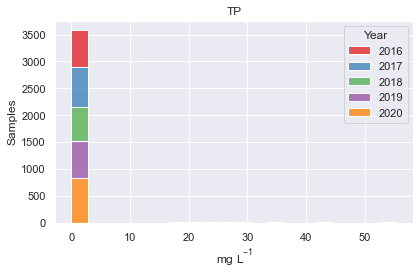

In [11]:
# Create and export histogram of daily water quality values
plot_wq_hist(obs_daily, param, f'{fig_dir}/{param}_obs_daily_hist.png')

In [12]:
# Get 99th quantile of daily values
quantile_99 = obs_daily['obs_value'].quantile(.99)

In [13]:
print(quantile_99)

0.24110000000000126


In [14]:
# Get observations with values greater than the 99th quantile
obs_daily[obs_daily['obs_value'] > quantile_99].sort_values('obs_value', ascending=False)

,site_code,obs_year,obs_month,obs_date,obs_value
896,SJA2858025,2016,1,2016-01-07,55.50
898,SJA2858025,2016,1,2016-01-09,43.50
895,SJA2858025,2016,1,2016-01-06,35.00
897,SJA2858025,2016,1,2016-01-08,33.50
899,SJA2858025,2016,1,2016-01-10,30.00
891,SJA2858025,2016,1,2016-01-02,30.00
894,SJA2858025,2016,1,2016-01-05,26.00
892,SJA2858025,2016,1,2016-01-03,24.00
893,SJA2858025,2016,1,2016-01-04,23.00
900,SJA2858025,2016,1,2016-01-11,19.50


## Monthly mean values

Site with the code SJA2858025 had values that exceeded the 99th quantile by several orders of magnitude. Before calculating monthly mean values the site with the extremely high values should be removed.

In [15]:
# Get monthly observation values
obs_monthly = get_monthly_obs(obs_daily[obs_daily['site_code'] != 'SJA2858025'].reset_index(drop=True))

In [16]:
display(obs_monthly.head())

,site_code,obs_year,obs_month,obs_value
0,SJA0008000,2016,8,0.056
1,SJA0008000,2016,10,0.037
2,SJA0008000,2016,11,0.032
3,SJA0030000,2018,3,0.028
4,SJA0030000,2018,5,0.040


In [17]:
print(obs_monthly['obs_value'].describe())

count    2562.000000
mean        0.052968
std         0.056960
min         0.006000
25%         0.030000
50%         0.042000
75%         0.060000
max         1.520000
Name: obs_value, dtype: float64


In [18]:
# Create DataFrame of monthly stats
obs_monthly_stats = []
for year, group in obs_monthly.groupby('obs_year'):
    stats_df = pd.DataFrame([extract_wq_stats(group)])
    stats_df.insert(0, 'Parameter', param.upper())
    stats_df.insert(1, 'Year', year)
    obs_monthly_stats.append(stats_df)
obs_monthly_stats = pd.concat(obs_monthly_stats).reset_index(drop=True)

In [19]:
display(obs_monthly_stats)

,Parameter,Year,Observations,Sites,Minimum,Mean,Maximum,Median,Standard deviation,Median observation count per site
0,TP,2016,481,120,0.010,0.064,1.52,0.048,0.101,4.0
1,TP,2017,552,134,0.006,0.045,0.20,0.040,0.025,4.0
2,TP,2018,438,115,0.009,0.051,0.63,0.040,0.048,4.0
3,TP,2019,473,126,0.006,0.048,0.30,0.040,0.036,4.0
4,TP,2020,618,146,0.006,0.058,0.38,0.045,0.046,4.0


In [20]:
# Export stats to CSV
obs_monthly_stats.to_csv(f'{stats_dir}/{param}_obs_monthly_stats.csv', sep=',', index=False)

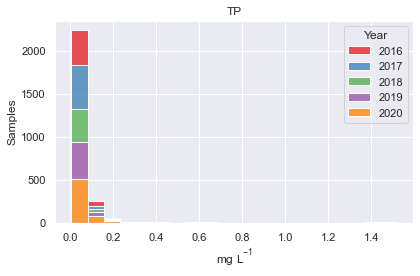

In [21]:
# Create and export histogram of monthly water quality values
plot_wq_hist(obs_monthly, param, f'{fig_dir}/{param}_obs_monthly_hist.png')

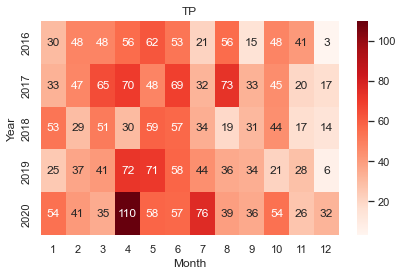

In [22]:
# Create and export heatmap of monthly observation values per year
plot_wq_heatmap(obs_monthly, param, f'{fig_dir}/{param}_obs_monthly_heat.png')

## Yearly mean values

In [23]:
# Extract sites with at least four distinct monthly observations in at least one of the years
four_distinct_monthly = obs_monthly.groupby(['site_code', 'obs_year'])['obs_value'].agg(['count'])\
    .pipe(lambda df: df.loc[df['count'] >= 4]).reset_index()['site_code'].unique()

In [24]:
# Extract daily observations based on the aforementioned criterion
obs_daily_four_distinct = obs_daily[obs_daily['site_code'].isin(four_distinct_monthly)].reset_index(drop=True)

In [25]:
print(obs_daily_four_distinct.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974 entries, 0 to 2973
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   site_code  2974 non-null   object 
 1   obs_year   2974 non-null   int64  
 2   obs_month  2974 non-null   int64  
 3   obs_date   2974 non-null   object 
 4   obs_value  2974 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 116.3+ KB
None


In [26]:
# Get yearly observation values
obs_yearly = get_yearly_obs(obs_daily_four_distinct[obs_daily_four_distinct['site_code'] != 'SJA2858025'].reset_index(drop=True))

In [27]:
display(obs_yearly.head())

,site_code,obs_year,obs_value
0,SJA0088000,2016,0.033
1,SJA0088000,2017,0.053
2,SJA0106000,2016,0.028
3,SJA0106000,2017,0.022
4,SJA0106000,2018,0.032


In [28]:
# Create DataFrame of yearly stats
obs_yearly_stats = pd.DataFrame([extract_wq_stats(obs_yearly)])
obs_yearly_stats = obs_yearly_stats.drop('Median observation count per site', axis=1)
obs_yearly_stats.insert(0, 'Parameter', param.upper())

In [29]:
display(obs_yearly_stats)

,Parameter,Observations,Sites,Minimum,Mean,Maximum,Median,Standard deviation
0,TP,470,242,0.008,0.051,0.27,0.044,0.032


In [30]:
# Export stats to CSV
obs_yearly_stats.to_csv(f'{stats_dir}/{param}_obs_yearly_stats.csv', sep=',', index=False)

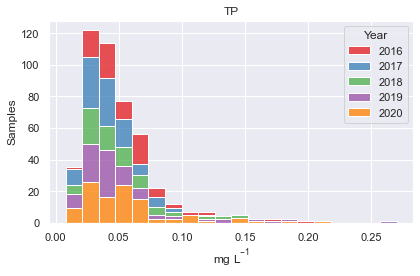

In [31]:
# Create and export histogram of yearly water quality values
plot_wq_hist(obs_yearly, param, f'{fig_dir}/{param}_obs_yearly_hist.png')